# `comp-01`: Representational similarity analysis (RSA)
This lab introduces representational similarity analysis (RSA) using two landmark datasets. Similarly to multivariate pattern classification, RSA captures the relationships among spatially distributed response patterns for different stimuli/conditions. However, rather than discretizing samples into two or more classes using a classification model, RSA simply measures the continuous similarity (or dissimilarity) between response patterns. Computing pairwise dissimilarities among response patterns yields a representational dissimilarity matrix (RDM), which can be compared to RDMs derived from other subjects, brain areas, species, or computational models ([Kriegeskorte et al., 2008a](https://doi.org/10.3389/neuro.06.004.2008)).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Visual object recognition dataset
We'll start applying RSA with our familiar visual object recognition fMRI dataset from [Haxby et al., 2001](https://doi.org/10.1126/science.1063736). Recall that participants were presented with images from 8 object categories (bottles, cats, chairs, faces, houses, scissors, scrambled images, and shoes) interspersed with periods of fixation (referred to as "rest" here). The TR in this study was 2.5 seconds. In a given run, a block of images from each of the 8 categories was presented one time. Each block was ~9 TRs long and contained multiple rapid presentations of images from a single category. A subject received 12 scanning runs. We'll focus on data from one subject for the purposes of this demo.

In [5]:
# Load the Haxby 2001 dataset and VT ROI mask
from nilearn import datasets
from nilearn.input_data import NiftiMasker

data_dir = 'comp-01/data'

haxby_dataset = datasets.fetch_haxby(data_dir=data_dir)
func_file = haxby_dataset.func[0]

# Load in mask for VT OI
mask_vt = haxby_dataset['mask_vt'][0]
masker_vt = NiftiMasker(mask_img=mask_vt)


Dataset created in comp-01/data/haxby2001



 ...done. (0 seconds, 0 min)
 ...done. (0 seconds, 0 min)


Downloaded 194330624 of 291168628 bytes (66.7%,    1.0s remaining) ...done. (3 seconds, 0 min)
Extracting data from comp-01/data/haxby2001/def37a305edfda829916fa14c9ea08f8/subj2-2010.01.14.tar.gz..... done.


In [6]:
# Load in session metadata as pandas DataFrame
session = pd.read_csv(haxby_dataset.session_target[0], sep=" ")

# Extract stimuli and run labels for this subject
stimuli, runs = session['labels'].values, session['chunks'].values

# Get list of unique stimulus categories (excluding rest)
categories = np.array([c for c in np.unique(stimuli) if c != 'rest'])

In [7]:
# Split functional image according to runs
from nilearn.image import index_img

func_runs = []
for run in np.unique(runs):
    func_runs.append(index_img(func_file, runs == run))

To prepare for RSA, we need response patterns corresponding to each of the 8 object categories in this dataset. To do this, we'll run a first-level GLM across all runs. This will yield a 8 maps of regression coefficients capturing responses to each of the 8 stimulus categories.

In [8]:
# Build first-level GLM for each run
from nilearn.glm.first_level import (make_first_level_design_matrix,
                                     FirstLevelModel)

# Set parameters for you design matrix
tr = 2.5
hrf_model = 'spm'
drift_model = 'cosine'
high_pass = 1/128

# Build a design matrix for each run
design_matrices = []
for run in np.unique(runs):
    stimuli_run = stimuli[runs == run]
    n_trs = len(stimuli_run)
    onsets = tr * np.arange(n_trs)
    duration = np.full(n_trs, tr)
    
    events_all = pd.DataFrame(
        {'onset': onsets, 'trial_type': stimuli_run, 'duration': duration})
    events = events_all[events_all['trial_type'] != 'rest']
    
    design_matrix = make_first_level_design_matrix(
        onsets,
        events,
        hrf_model=hrf_model,
        drift_model=drift_model,
        high_pass=high_pass)
    
    design_matrices.append(design_matrix)

In [9]:
# Define and fit GLM for all runs
glm = FirstLevelModel(t_r=tr,
                      mask_img=mask_vt,
                      standardize=True,
                      noise_model='ar1')

glm.fit(func_runs, design_matrices=design_matrices)

# Collate contrast maps for VT
glm_vt = []
for category in categories:
    glm_map = glm.compute_contrast(category)
    glm_vt.append(masker_vt.fit_transform(glm_map))

glm_vt = np.vstack(glm_vt)

/usr/people/iwahle/miniconda3/envs/neu502b/lib/python3.10/site-packages/nilearn/image/resampling.py:453: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn("The provided image has no sform in its header. "
/usr/people/iwahle/miniconda3/envs/neu502b/lib/python3.10/site-packages/nilearn/glm/first_level/first_level.py:688: UserWarning: One contrast given, assuming it for all 12 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


### Constructing a representational dissimilarity matrix (RDM)
To construct a representational dissimilarity matrix (RDM), we'll use SciPy's `pdist` to compute the pairwise distances between response patterns for each of the stimulus categories. We'll use *correlation distance* (i.e. $1 - r$) as our measure of dissimilarity according to the convention in the literature (note that Pearson correlation effectively normalizes the response patterns and has certain biases). The resulting RDM captures the *representational geometry* for the given stimulus set in our VT ROI. Since our RDM is symmetrical and the diagonal isn't very meaningful (representing a response pattern coorrelated with itself), we can more succinctly represent the RDM by vectorizing the cells in the off-diagonal triangle using the `squareform` function. The number of unique pairwise distances in the upper triangle of a $N \times N$ matrix is $N * (N - 1) / 2$; i.e. for our $8 \times 8$ matrix, there are $8 * (8 - 1) \mathbin{/} 2 = 28$ values in the off-diagonal triangle. Below, use `pdist` to compute the (vectorized off-diagonal triangle) RDM for VT cortex, then use `squareform` and `plt.matshow` (or `sns.heatmap`) to visualize the square RDM.

<AxesSubplot: >

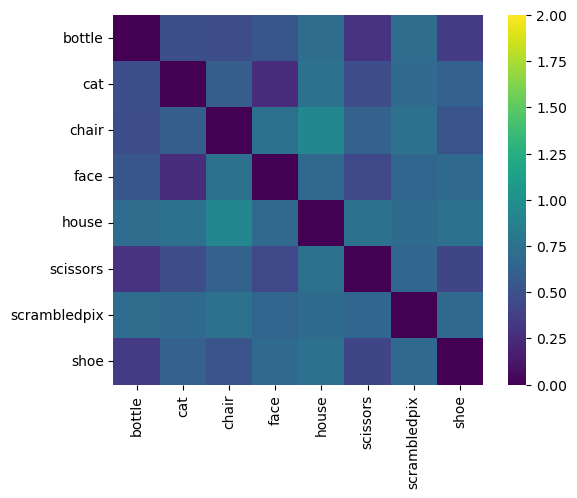

In [11]:
# Compute RDM with correlation distance:
from scipy.spatial.distance import pdist, squareform

pair = pdist(glm_vt, metric='correlation')

# Plot squareformed RDM:
rdm = squareform(pair)
sns.heatmap(rdm, square=True, cmap='viridis', xticklabels=categories,
            yticklabels=categories, cbar=True, vmin=0, vmax=2)

Currently the stimulus labels are alphabetically ordered. Let's try ordering them a bit more sensibly. Replot the RDM with reordered rows and columns.

Reordered categories: ['face' 'cat' 'bottle' 'shoe' 'scissors' 'chair' 'house' 'scrambledpix']


<AxesSubplot: >

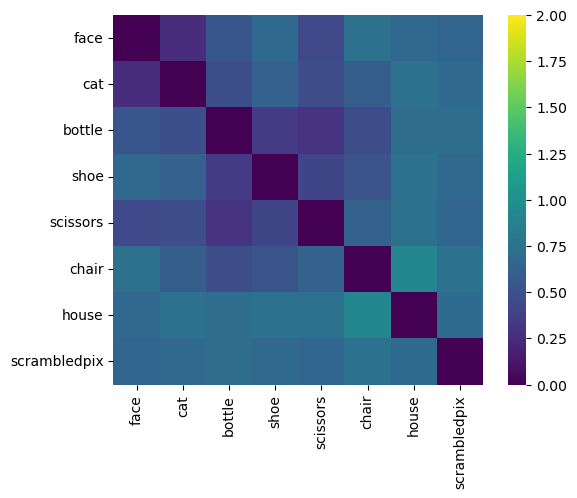

In [12]:
# Reorder RDM to reflect intuitive groups
reorder = [3, 1, 0, 7, 5, 2, 4, 6]
print(f"Reordered categories: {categories[reorder]}")

# Plot squareformed RDM with reordered rows/columns:
rdm = squareform(pair)[reorder, :][:, reorder]
sns.heatmap(rdm, square=True, cmap='viridis', xticklabels=categories[reorder],
            yticklabels=categories[reorder], cbar=True, vmin=0, vmax=2)


Note that we can also convert the correlation distance back to a correlation, resulting in an *similarity* matrix rather than a *dissimilarity* matix. Plot the correlation matrix corresponding to the RDM below.

<AxesSubplot: >

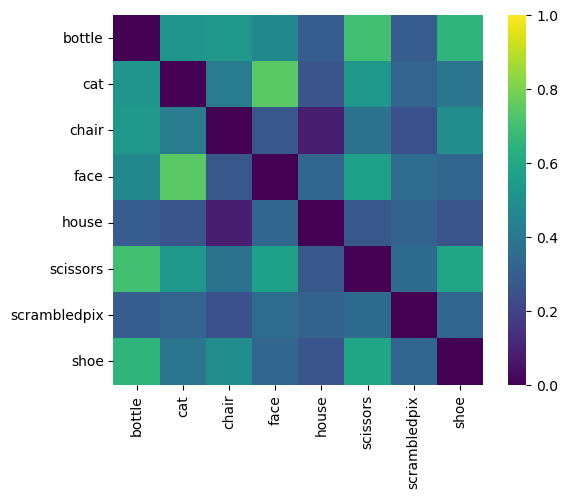

In [14]:
# Convert correlation distance to correlation:
corr = -(pair-1)

# Plot squareformed RDM:
sns.heatmap(squareform(corr), square=True, cmap='viridis', xticklabels=categories,
            yticklabels=categories, cbar=True, vmin=0, vmax=1)

Other distance metrics will yield different RDMs. For example, unlike correlation distance, Euclidean distance is sensitive to regional-average response magnitudes (i.e. the difference in overall activation levels across an ROI). Recompute and plot an RDM using Euclidean distance.

<AxesSubplot: >

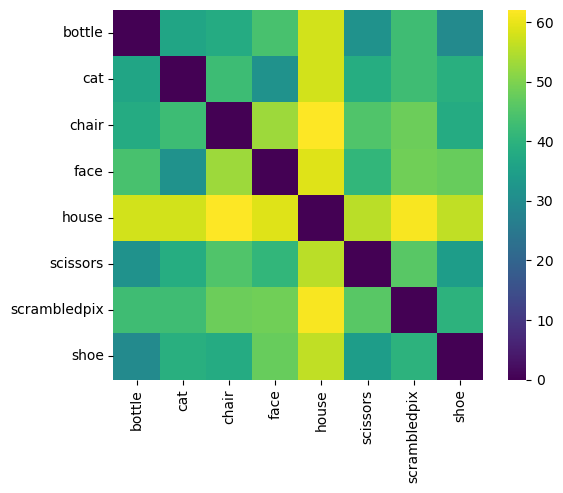

In [15]:
# Compute and plot RDM using Euclidean distance instead:
pair = pdist(glm_vt, metric='euclidean')

# Plot squareformed RDM:
sns.heatmap(squareform(pair), square=True, cmap='viridis', xticklabels=categories,
            yticklabels=categories, cbar=True)

### Comparing representational geometries
Our current *neural* RDM captures the representational geometry of VT cortex (for the current stimulus set). We can compare this RDM to *target* (or *model*) RDMs constructed to capture particular properties of the stimuli. For example, we'll manually construct an *animacy RDM* that captures the categorical relationship between human faces and cats—i.e. that they're both animate organisms, unlike scissors and chairs. We can also construct a *tool RDM* reflecting that scissors, bottles, and (arguably) shoes are all handheld, manipulable objects. In addition to simple categorical RDMs, we can also construct RDMs based on continuous features of the stimuli, like *real-world size*. We'll compare these target RDMs to the neural RDM using Spearman correlation. The "trick" of RSA is that no matter how we constructed these RDMs—whether they're based on computational models, behavioral judgments, response times, etc—we can always compare the second-order similarity structure captured by the RDMs.

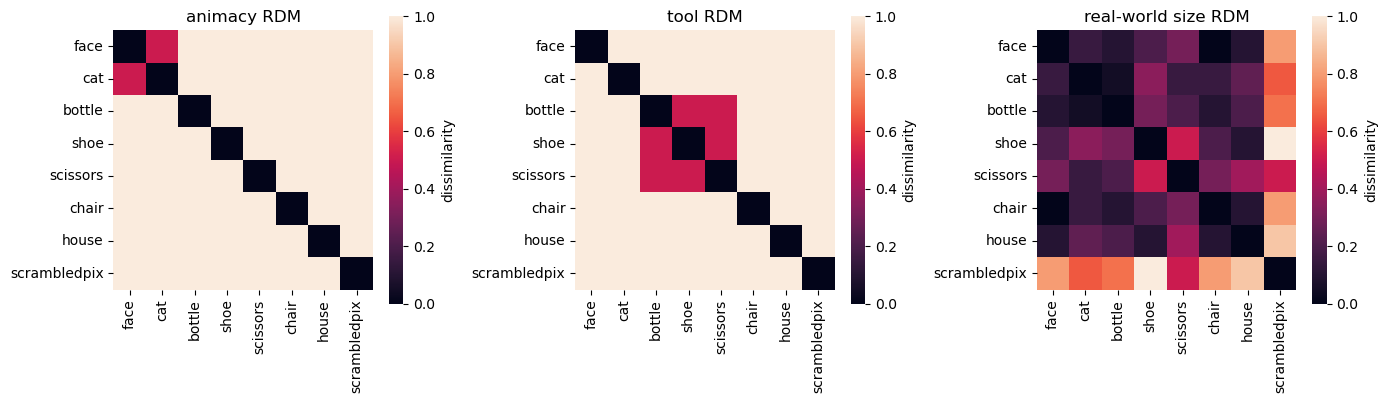

In [17]:
rdm_vt = pdist(glm_vt, metric='correlation')

# Set up simple animacy RDM
rdm_animacy = np.ones(len(rdm_vt))
rdm_animacy[8] = .5

# Set up simple tool RDM
rdm_tools = np.ones(len(rdm_vt))
rdm_tools[[4, 6, 26]] = .5

# Set up real-world size RDM
from itertools import combinations

sizes = [.3, .35, .2, .2, .1, .5, 1, 0]
rdm_size = []
for pair in combinations(sizes, 2):
    rdm_size.append(np.abs(pair[0] - pair[1]))

# Plot all three RDMs
rdms = {'animacy RDM': rdm_animacy,
        'tool RDM': rdm_tools,
        'real-world size RDM': rdm_size}

fig, axs = plt.subplots(1, 3, figsize=(14, 4))
for rdm, ax in zip(rdms, axs):
    sns.heatmap(squareform(rdms[rdm])[reorder][:, reorder],
                ax=ax, square=True,
                xticklabels=categories[reorder],
                yticklabels=categories[reorder],
                cbar_kws={'label': 'dissimilarity'})
    ax.set_title(rdm)
plt.tight_layout()

Compute the Spearman correlations between these "model" RDMs and the neural RDM for VT cortex.

In [21]:
# Compute correlations with VT RDM:
from scipy.stats import spearmanr
print(spearmanr(rdm_vt, rdm_animacy))
print(spearmanr(rdm_vt, rdm_tools))
print(spearmanr(rdm_vt, rdm_size))

SpearmanrResult(correlation=0.3216337604513384, pvalue=0.09511428531515403)
SpearmanrResult(correlation=0.49317176602538565, pvalue=0.007661454417297231)
SpearmanrResult(correlation=0.15633608670408466, pvalue=0.42693956951115986)


### Hierarchical clustering and dendrograms
It's not always easy to see the structure when looking directly at an RDM. One way to visualize an RDM is to cluster the response patterns based on their similarity. Here, we use agglomerative hierarchical clustering to cluster the RDMs, then visualize this cluster hierarchy using a dendrogram. Use `linkage` from `scipy.cluster.hierarchy` to compute the clusters and use `dendrogram` to visualize them. Try a couple different linkage functions (e.g. `'single'`, `'complete'`, `'ward'`).

/tmp/ipykernel_1490/2694102155.py:4: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  link = linkage(squareform(rdm_vt), method=lf)


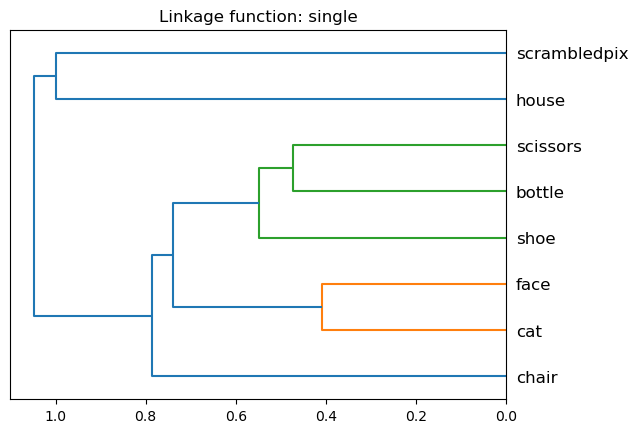

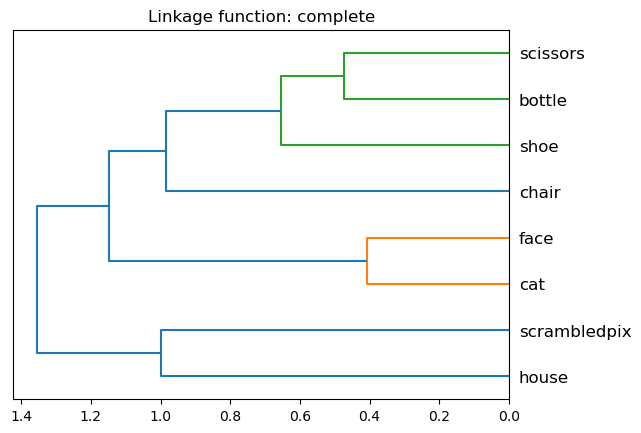

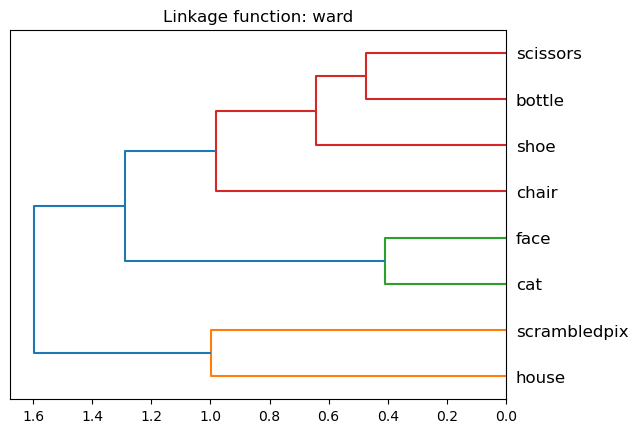

In [26]:
# Compute hierarchical clustering and plot dendrogram:
from scipy.cluster.hierarchy import dendrogram, linkage
for lf in ['single', 'complete', 'ward']:
    link = linkage(squareform(rdm_vt), method=lf)
    dend = dendrogram(link, labels=categories, orientation='left')
    plt.title(f"Linkage function: {lf}")
    plt.show()


### Multidimensional scaling (MDS)
Another common and intuitive way to visualize the structure of an RDM is to use multidimensional scaling (MDS). MDS finds a low-dimensional space (i.e. 2-dimensional for visualization) that best preserves the pairwise distances between response patterns. Use `MDS` from `sklearn.manifold` to estimate a 2-dimensional projection from the precomputed dissimilarity values, and plot the resulting positions below.

/usr/people/iwahle/miniconda3/envs/neu502b/lib/python3.10/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


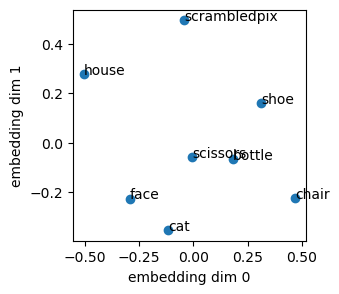

In [32]:
# Fit MDS to get positions in 2D space:
from sklearn.manifold import MDS
mds = MDS(n_components=2, dissimilarity='precomputed')
mds.fit(squareform(rdm_vt))

# Plot positions returned by MDS:
fig, ax = plt.subplots(figsize=(3,3))
ax.scatter(mds.embedding_[:, 0], mds.embedding_[:, 1])
for i, txt in enumerate(categories):
    ax.annotate(txt, (mds.embedding_[i, 0], mds.embedding_[i, 1]))
ax.set_xlabel('embedding dim 0')
ax.set_ylabel('embedding dim 1')
plt.show()

### Kriegeskorte dataset
The previous dataset only contains 8 stimulus categories, and therefore does not provide a very rich description of the representational geometry in VT cortex. The dataset that popularized RSA contains 96 object images from a variety of categories, including human faces and body parts, nonhuman animal faces and bodies, artificial (i.e. human-made) inanimate objects, and natural inanimate objects [Kriegeskorte et al., 2008b](https://doi.org/10.1016/j.neuron.2008.10.043). In the following, we'll load in response patterns for FFA and PPA and revisit some of the previous analyses with this richer dataset.

In [ ]:
# Load in Kriegeskorte fMRI data
kriegeskorte_dataset = np.load('kriegeskorte_dataset.npz',
                               allow_pickle=True)

roi_data = kriegeskorte_dataset['roi_data'].item()
category_names = kriegeskorte_dataset['category_names']
category_labels = kriegeskorte_dataset['category_labels']
images = kriegeskorte_dataset['images']

In [ ]:
# Plot 96 stimulus images with category labels
print("Category labels")
[print(f'{label}: {name}') for label, name in enumerate(category_names)]
fig, axs = plt.subplots(6, 16, figsize=(16, 6))
for image, label, ax in zip(images, category_labels, axs.flatten()):
    ax.imshow(image);
    ax.annotate(label, (.04, .77), color='white',
                xycoords='axes fraction')
    ax.set_axis_off()

First, combine (i.e. column-stack) all provided ROIs into a single VT ROI for subject `'TI'`.

In [ ]:
# Combine left/right FFA and PPA into single VT ROI:


Next, use `pdist` to compute the RDM based on correlation distance. Optionally, you may want to z-score each voxel across samples prior to computing the pairwise distances. Plot the resulting RDM. A simple `rank_percentile` function is provided to support visualizations similar to the original paper.

In [ ]:
# Simple rank percentile function
from scipy.stats import rankdata, zscore

def rank_percentile(a):
    return rankdata(a) / len(a) * 100

# Create neural RDM for VT and plot:


Finally, use MDS to visualize this more complex RDM. Color the resulting samples according to the six categories supplied with the dataset.

In [ ]:
# Fit MDS to get positions in 2D space:
from sklearn.manifold import MDS


# Plot positions returned by MDS:


#### References
* Haxby, J. V., Gobbini, M. I., Furey, M. L., Ishai, A., Schouten, J. L., & Pietrini, P. (2001). Distributed and overlapping representations of faces and objects in ventral temporal cortex. *Science*, *293*(5539), 2425–2430. https://doi.org/10.1126/science.1063736

* Kriegeskorte, N., Mur, M., & Bandettini, P. A. (2008a). Representational similarity analysis—connecting the branches of systems neuroscience. *Frontiers in Systems Neuroscience*, *2*, 4. https://doi.org/10.3389/neuro.06.004.2008

* Kriegeskorte, N., Mur, M., Ruff, D. A., Kiani, R., Bodurka, J., Esteky, H., Tanaka, K., & Bandettini, P. A. (2008b). Matching categorical object representations in inferior temporal cortex of man and monkey. *Neuron*, *60*(6), 1126–1141. https://doi.org/10.1016/j.neuron.2008.10.043